This based on an R runtime. Please make sure to initialize R to run this notebook

MARS is a bunch of small straight lines called splines which are piecewise linear functions that bend or break at different knots.

It identifies the knots and adds the splines. At the end the model goes back to remove the least important onces (prunning)

Things to do:

*   remove ouliers from the dataset
*   address correlation issues

In [3]:
install.packages("earth")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plotrix’, ‘Formula’, ‘plotmo’




In [4]:
#Essential libraries


library(readxl)
library(earth)
library(dplyr)
library(purrr)
library(tidyr)
library(ggplot2)
library(magrittr)

Loading required package: Formula

Loading required package: plotmo

Loading required package: plotrix


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract


The following object is masked from ‘package:purrr’:

    set_names




## Base model

In [ ]:
# Install the 'earth' package (only needs to be run once) but if you are using a virtual notebook like non-system contained notebook, you probably need to rereun.
# install.packages("earth")
# install.packages("readxl")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plotrix’, ‘Formula’, ‘plotmo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# ----------------------------------------------------
# Loading datasets WITHOUT interaction terms
# ----------------------------------------------------

#you do not need to standardize this model, but you need to standardize the MLR model
#X = indpendent variables and Y = dependent variables

X_train <- read_excel("X_train.xlsx")
X_test <- read_excel("X_test.xlsx")
y_train <- read_excel("y_train.xlsx")
y_test <- read_excel("y_test.xlsx")

# Combine the training features and the target variable into one data frame
train_df <- cbind(y_train, X_train)

# View the first few rows to confirm the combination was successful
head(train_df)

,PWP,sand,silt,clay,active_carbon,respiration,ag_stability,BNA,ph,p_index,c_nratio,per_carbon,per_nitrogen
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.104000,59.0,31.7,9.3,343,0.85,49.1,36.1,5.1,9.04,9.53,1.62,0.17
2,0.107870,60.7,26.1,13.2,301,0.37,24.1,22.8,5.5,14.62,11.58,1.39,0.12
3,0.117447,49.6,39.9,10.5,422,0.71,31.2,48.7,5.7,17.43,13.13,1.97,0.15
4,0.083000,62.3,26.4,11.3,340,0.46,38.5,25.8,5.2,9.72,13.08,1.57,0.10
5,0.087601,66.0,26.4,7.5,361,0.62,23.2,24.4,5.6,25.51,12.64,1.39,0.11
6,0.094000,60.2,27.0,12.8,306,0.71,26.4,32.5,6.4,14.16,8.29,1.16,0.26


In [ ]:
# sapply(train_df, is.numeric)
# sapply(X_test, is.numeric)

# names(y_train)[1] <- "PWP"
# names(y_test)[1]  <- "PWP"

# Quick sanity checks
# stopifnot(is.numeric(train_df$PWP))
# stopifnot(all(names(X_train) == names(X_test)))  # same predictors/order

In [ ]:
set.seed(100)

# Fit MARS (baseline, no tuning)
mars_model <- earth(PWP ~ ., data = train_df)

# Predict on test features
summary(mars_model) #this will give you the rsq from the training dataset

Call: earth(formula=PWP~., data=train_df)

                     coefficients
(Intercept)           0.176722420
h(46-sand)            0.004273719
h(sand-46)           -0.010042925
h(sand-51.5)          0.008692911
h(silt-38.8)         -0.008412400
h(0.81-respiration)  -0.031171589
h(30.5-ag_stability)  0.000935664
h(ag_stability-30.5) -0.000365001
h(5.29-p_index)       0.003050443
h(1.62-per_carbon)   -0.012620663
h(per_carbon-1.62)    0.019439423

Selected 11 of 22 terms, and 6 of 12 predictors
Termination condition: RSq changed by less than 0.001 at 22 terms
Importance: sand, silt, ag_stability, per_carbon, respiration, p_index, ...
Number of terms at each degree of interaction: 1 10 (additive model)
GCV 0.0002200888    RSS 0.0897923    GRSq 0.6165225    RSq 0.6499973

In [ ]:
predictions_base <- predict(mars_model, newdata = X_test)

In [ ]:
#Building the code to assess the accuracy of the model
# y_test_vec <- y_test$PWP  # same as y_test[[1]]

# If there are any NAs in either vector, you can drop them pairwise:
# keep <- !is.na(predictions) & !is.na(y_test_vec) #this is just a sanity check, I had issues with my previous code.
# rsq_base <- mars_model$rsq #extracting the rsq from the mars model
r2_base   <- cor(y_test[[1]], predictions_base)^2  #this is the rquare from the training test datset
mae_base  <- mean(abs(predictions_base - y_test[[1]]))
rmse_base <- sqrt(mean((predictions_base - y_test[[1]])^2))

# print(paste("Mean Absolute Error:", round(mae_base, 4)))
# print(paste("Root Mean Squared Error:", round(rmse_base, 4)))

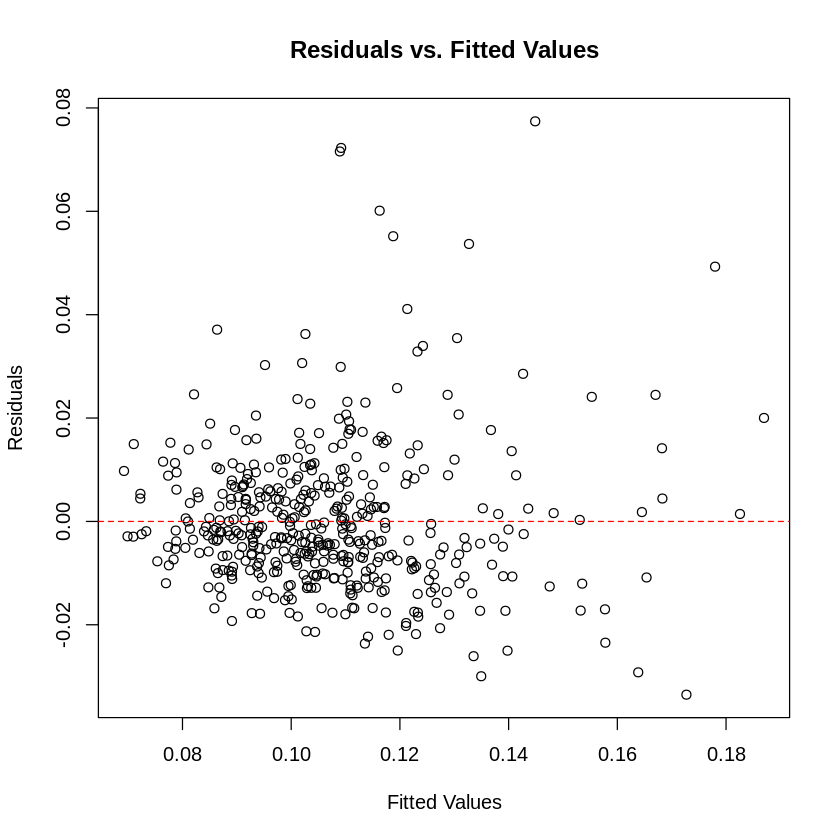

In [ ]:
#plotting the RSS and RSQ

residuals <- residuals(mars_model)
fitted_values <- fitted(mars_model)

plot(fitted_values, residuals,xlab = "Fitted Values",ylab = "Residuals",main = "Residuals vs. Fitted Values")
abline(h = 0, col = "red", lty = 2) # Add a horizontal line at 0

In [ ]:
mars_model$nk

[1] 25

[1] 0.0897923

[1] 0.6499973

In [ ]:
metrics_df <- data.frame(
  Metric = c("R-squared", "RMSE", "MAE"),
  Value = c(r2_base, rmse_base, mae_base)
)

print(metrics_df)

     Metric     Value
1 R-squared 0.5607060
2      RMSE 0.0142785
3       MAE 0.0111162


Inference:

From the output of the base model, the model fits better than the MLR model initially trained. This is because the MARS model does better in extending linear relationships to non-linear relationships. The Rsq shows that it fits 64% variation in PWP is explained that the seleted terms and predictors. Mind you, MARS includes a feature selection approach through its backward pass process.

The RSS 0.089 means that 8% sqaured error between the actual vs the predicted value. This is quite low and tracks along the R2 value. But ofcourse, there is still room for improvement. The model is showing signs of potential inaccurate prediction of larger values seeing how the errors start scattering as the values increase.

It is also important to note that the model is showing signs of influential outliers.

## **Tune model**

### **Tune model (GCV replaced by CV)**

**Tune model (GCV replaced by K fold)**

So it is very important to know that the starting point of your parameters matter especially if the variables thenselves have a complicated relationship.

**nk (max number of terms)** should be set to a larger value. It is should be considerably larger than the optimal GCV model.

**thresh** - This should be set to a smaller value to allow the model run with more flexibilty.

**minspan and endspan**- These numbers should be small as well.

In [ ]:
set.seed(100)

rmse <- function(y, yhat) sqrt(mean((y - yhat)^2))
mae  <- function(y, yhat) mean(abs(y - yhat))

grid <- crossing(
  degree  = c(1, 2, 3),  # interaction order ( 1 = additive, 2 for two way interactions , 3 = for three way interactions)) Rarely is there any benefit in assessing greater than 3-rd degree interactions
  nk      = c(50,70, 80, 90, 100),
  minspan = 1,   # max terms grown in forward pass (friedman)
  endspan = c(10, 15, 30)     # knot spacing guardrail
)

results <- pmap_dfr(grid, function(degree, nk, minspan, endspan) {
  mars_tuned_gcv <- earth(PWP ~ ., data = train_df,
               degree = degree,
               nprune = NULL,   # let the earth package selfprune
               nk = nk,
               minspan = minspan,
               endspan = endspan,
               pmethod="cv", # add this to use CV-based pruning instead of GCV
               nfold = 5, # nfold = 10, ncross = 1
               ncross = 3)

  summary_info <- summary(mars_tuned_gcv2)

  tibble(
    degree = degree, nk = nk, minspan = minspan, endspan = endspan,
    R2 = summary_info$rsq,
    GCV_R2 = summary_info$grsq,
    GCV = summary_info$gcv
    )
})
# Display the results
results %>% arrange(desc(R2))

degree,nk,minspan,endspan,RMSE,MAE,R2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>"
1,80,1,15,0.01238062,0.009522584,0.643239


In [ ]:
set.seed(100)
#tunning again based on the a smaller value of nk and endspan

grid <- crossing(
  degree = 1, #degree 1
  nk= 70:90, #nk
  minspan = 1,
  endspan = 15:25
)

results <- pmap_dfr(grid, function(degree, nk, minspan, endspan) {
  mars_tuned_gcv2 <- earth(PWP ~ ., data = train_df,
                degree = degree,
                nprune = NULL,
                nk = nk,
                minspan = minspan,
                endspan = endspan,
                pmethod="cv",
                nfold = 5,
                ncross = 3)

  #Extract summary statistics from the model object
  summary_info <- summary(mars_tuned_gcv2)

  tibble(
    degree = degree, nk = nk, minspan = minspan, endspan = endspan,
    R2 = summary_info$rsq,
    GCV_R2 = summary_info$grsq,
    GCV = summary_info$gcv
    )
})

# Display the results
results %>% arrange(desc(GCV_R2)) %>% slice_head(n = 3)

degree,nk,minspan,endspan,R2,GCV_R2,GCV
<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,78,1,15,0.6474263,0.6137056,0.0002217055
1,87,1,15,0.6598593,0.6129955,0.0002221130
1,81,1,16,0.6466805,0.6128885,0.0002221744


Running the model with the best performing parameters

In [ ]:
# I want to see how the parameters were performing on thr training dataset only
final_model_gcv <- earth(PWP ~ ., data = train_df, degree = 1, nprune = NULL, nk = 78, minspan = 1,endspan = 15,pmethod="cv", nfold = 5, ncross = 3)

# Predict on test features
summary(final_model_gcv) #this will give you the rsq from the training dataset

Call: earth(formula=PWP~., data=train_df, pmethod="cv", degree=1, nprune=NULL,
            nfold=5, ncross=3, nk=78, minspan=1, endspan=15)

                     coefficients
(Intercept)           0.167677461
h(sand-47.1)         -0.010818983
h(sand-51.5)          0.009333822
h(silt-37.2)         -0.003851093
h(0.81-respiration)  -0.031027394
h(30.4-ag_stability)  0.000911537
h(ag_stability-30.4) -0.000290216
h(per_carbon-1.57)    0.020451941

Selected 8 of 23 terms, and 5 of 12 predictors (pmethod="cv")
Termination condition: RSq changed by less than 0.001 at 23 terms
Importance: sand, ag_stability, per_carbon, respiration, silt, clay-unused, ...
Number of terms at each degree of interaction: 1 7 (additive model)
GRSq 0.6051428  RSq 0.6294357  mean.oof.RSq 0.4749824 (sd 0.26)

pmethod="backward" would have selected:
    11 terms 6 preds,  GRSq 0.6137056  RSq 0.6474263  mean.oof.RSq 0.4720893

In [ ]:
pred_gcv <- predict(final_model_gcv, newdata = X_test)

In [ ]:
RMSE = rmse(y_test[[1]], pred_gcv)
MAE  = mae (y_test[[1]], pred_gcv)
R2   = cor(y_test[[1]], pred_gcv)^2

In [ ]:
metrics_df <- data.frame(
  Metric = c("R-squared", "RMSE", "MAE"),
  Value = c(R2, RMSE, MAE)
)

print(metrics_df)

     Metric      Value
1 R-squared 0.59835873
2      RMSE 0.01341427
3       MAE 0.01050624


### **Tune model (uses GCV)**

In [ ]:
set.seed(100)

make_folds <- function(n, k = 5) {
  x <- sample(rep(1:k, length.out = n)) #randomly samples the data so that there are random folds. Instead of having data points  1- 3 in fold 1, 4 - 6 in fold 2, this will assign them randomly in the "x" variable
  split(seq_len(n), x) #creates a blank sequence of integers that matches the data points in the original dataset, and then splits it up based on the corresponding "x" variabe value
}

# n is the number of total observations or basically the data points, k is the number of folds and we are starting at 5. This can be specified to a different number when calling the function.
# rep () This repeats the sequence 1:k until it has a total length of n. For example, if n is 10 and k is 3, the result would be c(1, 2, 3, 1, 2, 3, 1, 2, 3, 1).

In [ ]:
#base metrices. R-squared is provided as a stat in the earth package, so no need to calculate separately.
rmse <- function(y, yhat) sqrt(mean((y - yhat)^2))
mae  <- function(y, yhat) mean(abs(y - yhat))

In [ ]:
grid <- crossing(
  degree  = c(1, 2, 3),        # interaction order ( 1 = additive, 2 for two way interactions , 3 = for three way interactions)) Rarely is there any benefit in assessing greater than 3-rd degree interactions
  nk      = c(50,70, 80, 90, 100),    # max terms grown in forward pass (friedman) # thresh  = c(0, 0.0001, 0.001),
  nprune = c(20,40,60,80,100),
  minspan = 1,
  endspan = c(10, 15, 30)     # knot spacing guardrail
)

K_OUTER   <- 5        # 5 fold CV

In [ ]:
results <- pmap_dfr(grid, function(degree, nk, nprune, minspan, endspan) { #removed thresh,
  folds <- make_folds(nrow(train_df), k = K_OUTER)

  fold_stats <- lapply(folds, function(x) {
    tr_vec <- setdiff(seq_len(nrow(train_df)), x)
    tr_subset <- train_df[tr_vec, , drop = FALSE]
    te_subset <- train_df[x, , drop = FALSE]

    fit <- earth(PWP ~ ., data = tr_subset, degree = degree,nk = nk, minspan = minspan, endspan = endspan, nprune = nprune) #thresh = thresh removed threshold

    preds <- predict(fit, newdata = te_subset)

    c(RMSE = rmse(te_subset$PWP, preds),MAE  = mae (te_subset$PWP, preds),R2 = cor(te_subset$PWP, preds)^2)
  })

  fold_mat <- do.call(rbind, fold_stats)
  tibble(
    degree = degree, nk = nk, nprune = nprune, minspan = minspan, endspan = endspan, #thresh = thresh removed threhold
    RMSE = mean(fold_mat[, "RMSE"]),
    MAE = mean(fold_mat[, "MAE"]),
    R2 = mean(fold_mat[, "R2"])
  )
})


best_GCV <- results %>% arrange(RMSE, MAE) %>% slice(3)
best_GCV

degree,nk,nprune,minspan,endspan,RMSE,MAE,R2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,70,80,1,30,0.0155682,0.01099927,0.5675812


Second tuning pass

In [ ]:
grid <- crossing(
  degree  = 1, nk = 50:70, nprune = 79:90, minspan = 1, endspan = 25:40
)

K_OUTER   <- 5        # 5 fold CV

In [ ]:
set.seed(100)

results <- pmap_dfr(grid, function(degree, nk, nprune, minspan, endspan) {
  folds <- make_folds(nrow(train_df), k = K_OUTER)

  fold_stats <- lapply(folds, function(x) {
    tr_vec <- setdiff(seq_len(nrow(train_df)), x)
    tr_subset <- train_df[tr_vec, , drop = FALSE]
    te_subset <- train_df[x, , drop = FALSE]

    fit <- earth(PWP ~ ., data = tr_subset, degree = degree,nk = nk, nprune = nprune, minspan = minspan, endspan = endspan) #thresh = thresh removed threshold

    preds <- predict(fit, newdata = te_subset)

    # p = length(coef(fit))

    c(RMSE = rmse(te_subset$PWP, preds),MAE  = mae (te_subset$PWP, preds),R2   = cor(te_subset$PWP, preds)^2)
  })

  fold_mat <- do.call(rbind, fold_stats)
  tibble(
    degree = degree, nk = nk, nprune = nprune, minspan = minspan, endspan = endspan, #thresh = thresh removed threhold
    RMSE = mean(fold_mat[, "RMSE"]),
    MAE = mean(fold_mat[, "MAE"]),
    R2 = mean(fold_mat[, "R2"])
  )
})


best_secondrun_GCV <- results %>% arrange(RMSE, MAE) %>% slice(1)
best_secondrun_GCV

degree,nk,nprune,minspan,endspan,RMSE,MAE,R2
<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,53,83,1,27,0.01497509,0.01078176,0.6135889


Final Model run of the best peforming parameters

In [ ]:
final_model <- earth(
  PWP ~ ., data = train_df,
  degree  = 1,
  nk      = 53,
  minspan = 1,
  endspan = 27,
  nprune  = 83
)

# Inspect the fitted, GCV-pruned model
summary(final_model)
# Optional:
# evimp(final_model)
# plot(final_model)       # GCV vs number of terms path
# plotmo(final_model)     # partial dependence style plots (if plotmo installed)

rmse <- function(y, yhat) sqrt(mean((y - yhat)^2))
mae  <- function(y, yhat) mean(abs(y - yhat))

# Evaluate on your held-out test set
pred_test <- predict(final_model, newdata = X_test)
final_mae  <- mae (y_test[[1]], pred_test)
final_rmse <- rmse(y_test[[1]], pred_test)
final_r2   <- cor(y_test[[1]], pred_test)^2
# p_ = length(coef(final_model))

# cat(sprintf("Test MAE = %.4f | RMSE = %.4f | R^2 = %.4f\n", final_mae, final_rmse, final_r2))

Call: earth(formula=PWP~., data=train_df, degree=1, nprune=83, nk=53,
            minspan=1, endspan=27)

                     coefficients
(Intercept)           0.050767609
h(sand-51.7)          0.006292398
h(61.5-sand)          0.007372088
h(sand-61.5)         -0.007466762
h(silt-39.9)         -0.010472896
h(13.2-clay)         -0.001060799
h(0.81-respiration)  -0.033349551
h(30.4-ag_stability)  0.000935600
h(ag_stability-30.4) -0.000341567
h(5.29-p_index)       0.003262187
h(1.62-per_carbon)   -0.013090023
h(per_carbon-1.62)    0.019173386

Selected 12 of 22 terms, and 7 of 12 predictors (nprune=83)
Termination condition: RSq changed by less than 0.001 at 22 terms
Importance: sand, per_carbon, silt, ag_stability, respiration, p_index, ...
Number of terms at each degree of interaction: 1 11 (additive model)
GCV 0.0002245798    RSS 0.09077027    GRSq 0.6086973    RSq 0.6461852

In [ ]:
metrics_test <- data.frame(
  Metric = c("MAE", "RMSE", "R-squared"),
  Value = c(final_mae, final_rmse, final_r2)
)

print(metrics_test)

     Metric      Value
1       MAE 0.01127206
2      RMSE 0.01430317
3 R-squared 0.55170521


### **Tune model (uses GCV) but for models with outliers removed**

In [5]:
# ----------------------------------------------------
# Loading datasets WITH outliers removed
# ----------------------------------------------------

#you do not need to standardize this model, but you need to standardize the MLR model
#X = indpendent variables and Y = dependent variables

X_train <- read_excel("X_train_outliers.xlsx")
X_test <- read_excel("X_test_outliers.xlsx")
y_train <- read_excel("y_train_outliers.xlsx")
y_test <- read_excel("y_test_outliers.xlsx")

# Combine the training features and the target variable into one data frame
train_df <- cbind(y_train, X_train)

# View the first few rows to confirm the combination was successful
head(train_df)

,PWP,sand,silt,clay,active_carbon,respiration,ag_stability,BNA,ph,p_index,c_nratio,per_carbon,per_nitrogen
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.08837500,64.6,27.6,7.8,343,0.76,83.9,30.2,5.6,6.13,12.46,1.62,0.13
2,0.09810555,61.6,28.5,9.9,588,1.00,64.0,48.7,7.0,8.00,13.44,2.15,0.16
3,0.11700000,54.3,36.5,9.1,556,0.95,69.7,48.9,6.5,12.41,10.48,2.20,0.21
4,0.12763069,53.1,38.3,8.5,419,0.68,31.8,30.9,6.2,11.09,13.38,1.74,0.13
5,0.08491848,69.6,23.6,6.8,345,0.78,70.9,44.3,5.9,6.37,12.46,1.62,0.13
6,0.08639456,68.1,24.9,7.0,293,0.73,51.5,26.5,5.8,12.91,12.08,1.57,0.13


In [6]:
set.seed(100)

make_folds <- function(n, k = 5) {
  x <- sample(rep(1:k, length.out = n)) #randomly samples the data so that there are random folds. Instead of having data points  1- 3 in fold 1, 4 - 6 in fold 2, this will assign them randomly in the "x" variable
  split(seq_len(n), x) #creates a blank sequence of integers that matches the data points in the original dataset, and then splits it up based on the corresponding "x" variabe value
}

# n is the number of total observations or basically the data points, k is the number of folds and we are starting at 5. This can be specified to a different number when calling the function.
# rep () This repeats the sequence 1:k until it has a total length of n. For example, if n is 10 and k is 3, the result would be c(1, 2, 3, 1, 2, 3, 1, 2, 3, 1).

In [7]:
#base metrices. R-squared is provided as a stat in the earth package, so no need to calculate separately.
rmse <- function(y, yhat) sqrt(mean((y - yhat)^2))
mae  <- function(y, yhat) mean(abs(y - yhat))

In [8]:
grid <- crossing(
  degree  = c(1, 2, 3),        # interaction order ( 1 = additive, 2 for two way interactions , 3 = for three way interactions)) Rarely is there any benefit in assessing greater than 3-rd degree interactions
  nk      = c(50,70, 80, 90, 100),    # max terms grown in forward pass (friedman) # thresh  = c(0, 0.0001, 0.001),
  nprune = c(20,40,60,80,100),
  minspan = 1,
  endspan = c(10, 15, 30)     # knot spacing guardrail
)

K_OUTER   <- 5        # 5 fold CV

In [9]:
results <- pmap_dfr(grid, function(degree, nk, nprune, minspan, endspan) { #removed thresh,
  folds <- make_folds(nrow(train_df), k = K_OUTER)

  fold_stats <- lapply(folds, function(x) {
    tr_vec <- setdiff(seq_len(nrow(train_df)), x)
    tr_subset <- train_df[tr_vec, , drop = FALSE]
    te_subset <- train_df[x, , drop = FALSE]

    fit <- earth(PWP ~ ., data = tr_subset, degree = degree,nk = nk, minspan = minspan, endspan = endspan, nprune = nprune) #thresh = thresh removed threshold

    preds <- predict(fit, newdata = te_subset)

    c(RMSE = rmse(te_subset$PWP, preds),MAE  = mae (te_subset$PWP, preds),R2 = cor(te_subset$PWP, preds)^2)
  })

  fold_mat <- do.call(rbind, fold_stats)
  tibble(
    degree = degree, nk = nk, nprune = nprune, minspan = minspan, endspan = endspan, #thresh = thresh removed threhold
    RMSE = mean(fold_mat[, "RMSE"]),
    MAE = mean(fold_mat[, "MAE"]),
    R2 = mean(fold_mat[, "R2"])
  )
})


best_GCV <- results %>% arrange(RMSE, MAE) %>% slice(3)
best_GCV

degree,nk,nprune,minspan,endspan,RMSE,MAE,R2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,50,20,1,30,0.01097375,0.008703763,0.524639


Second tuning pass

In [10]:
grid <- crossing(
  degree  = 1, nk = 40:60, nprune = 10:30, minspan = 1, endspan = 25:40
)

K_OUTER   <- 5        # 5 fold CV

In [11]:
set.seed(100)

results <- pmap_dfr(grid, function(degree, nk, nprune, minspan, endspan) {
  folds <- make_folds(nrow(train_df), k = K_OUTER)

  fold_stats <- lapply(folds, function(x) {
    tr_vec <- setdiff(seq_len(nrow(train_df)), x)
    tr_subset <- train_df[tr_vec, , drop = FALSE]
    te_subset <- train_df[x, , drop = FALSE]

    fit <- earth(PWP ~ ., data = tr_subset, degree = degree,nk = nk, nprune = nprune, minspan = minspan, endspan = endspan) #thresh = thresh removed threshold

    preds <- predict(fit, newdata = te_subset)

    # p = length(coef(fit))

    c(RMSE = rmse(te_subset$PWP, preds),MAE  = mae (te_subset$PWP, preds),R2   = cor(te_subset$PWP, preds)^2)
  })

  fold_mat <- do.call(rbind, fold_stats)
  tibble(
    degree = degree, nk = nk, nprune = nprune, minspan = minspan, endspan = endspan, #thresh = thresh removed threhold
    RMSE = mean(fold_mat[, "RMSE"]),
    MAE = mean(fold_mat[, "MAE"]),
    R2 = mean(fold_mat[, "R2"])
  )
})


best_secondrun_GCV <- results %>% arrange(RMSE, MAE) %>% slice(1)
best_secondrun_GCV

degree,nk,nprune,minspan,endspan,RMSE,MAE,R2
<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,51,23,1,29,0.01059692,0.008331342,0.5548832


Final Model run of the best peforming parameters

In [12]:
final_model <- earth(
  PWP ~ ., data = train_df,
  degree  = 1,
  nk      = 51,
  minspan = 1,
  endspan = 29,
  nprune  = 23
)

# Inspect the fitted, GCV-pruned model
summary(final_model)
# Optional:
# evimp(final_model)
# plot(final_model)       # GCV vs number of terms path
# plotmo(final_model)     # partial dependence style plots (if plotmo installed)

rmse <- function(y, yhat) sqrt(mean((y - yhat)^2))
mae  <- function(y, yhat) mean(abs(y - yhat))

# Evaluate on your held-out test set
pred_test <- predict(final_model, newdata = X_test)
final_mae  <- mae (y_test[[1]], pred_test)
final_rmse <- rmse(y_test[[1]], pred_test)
final_r2   <- cor(y_test[[1]], pred_test)^2
# p_ = length(coef(final_model))

# cat(sprintf("Test MAE = %.4f | RMSE = %.4f | R^2 = %.4f\n", final_mae, final_rmse, final_r2))

Call: earth(formula=PWP~., data=train_df, degree=1, nprune=23, nk=51,
            minspan=1, endspan=29)

                     coefficients
(Intercept)           0.095424931
h(66.3-sand)          0.001515509
h(sand-66.3)         -0.004704554
h(26.4-silt)          0.002707778
h(0.51-respiration)  -0.064418176
h(32.6-ag_stability)  0.000761278
h(24-BNA)             0.001103313
h(ph-5.4)             0.002889341
h(13.93-p_index)     -0.000731694
h(p_index-13.93)     -0.000712573
h(11.28-c_nratio)     0.002769213
h(1.86-per_carbon)   -0.013766915
h(per_carbon-1.86)    0.031876077
h(per_nitrogen-0.13) -0.061097031

Selected 14 of 21 terms, and 10 of 12 predictors (nprune=23)
Termination condition: RSq changed by less than 0.001 at 21 terms
Importance: sand, per_carbon, ag_stability, p_index, respiration, silt, ...
Number of terms at each degree of interaction: 1 13 (additive model)
GCV 0.0001149749    RSS 0.03598684    GRSq 0.547316    RSq 0.6096755

In [13]:
metrics_test <- data.frame(
  Metric = c("MAE", "RMSE", "R-squared"),
  Value = c(final_mae, final_rmse, final_r2)
)

print(metrics_test)

     Metric       Value
1       MAE 0.007880992
2      RMSE 0.009908356
3 R-squared 0.660999540


## **Model Plots**

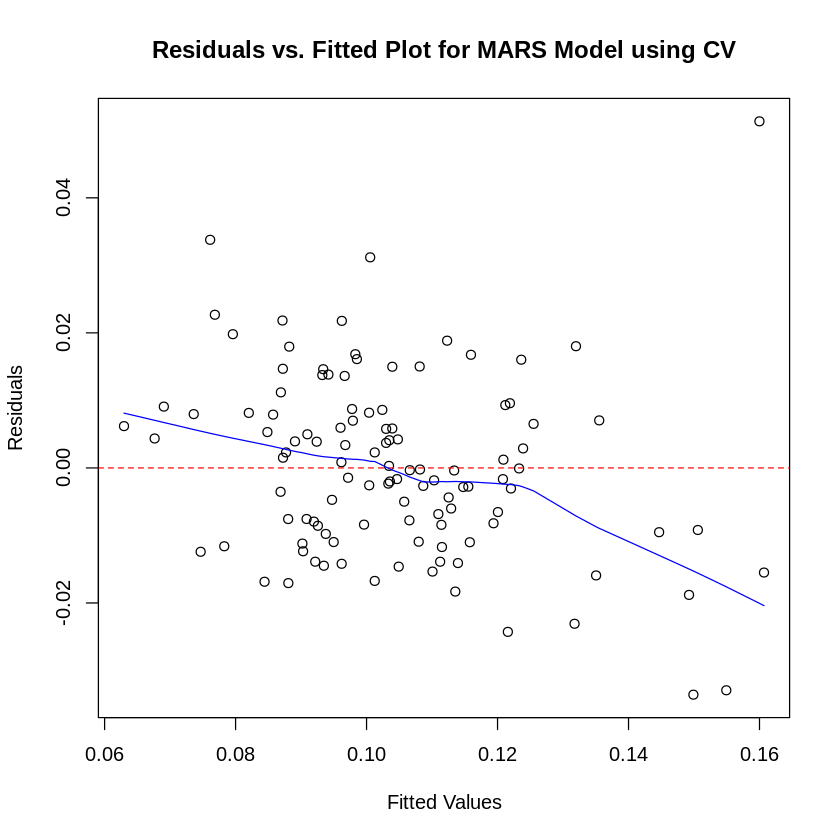

In [ ]:
#for GCV replaced by CV (USED KFOLD)
#the prediction code line is
#pred_gcv <- predict(final_model_gcv, newdata = X_test)
fitted_values <- pred_gcv
residuals <- y_test[[1]] - pred_gcv

plot(fitted_values, residuals,
     main = "Residuals vs. Fitted Plot for MARS Model using CV", #uses  CV for internal prunning
     xlab = "Fitted Values",
     ylab = "Residuals")

# Add a horizontal line at y=0 for reference
abline(h = 0, col = "red", lty = 2)

# Optional: Add a LOESS smooth line to see patterns
lines(lowess(fitted_values, residuals), col = "blue")

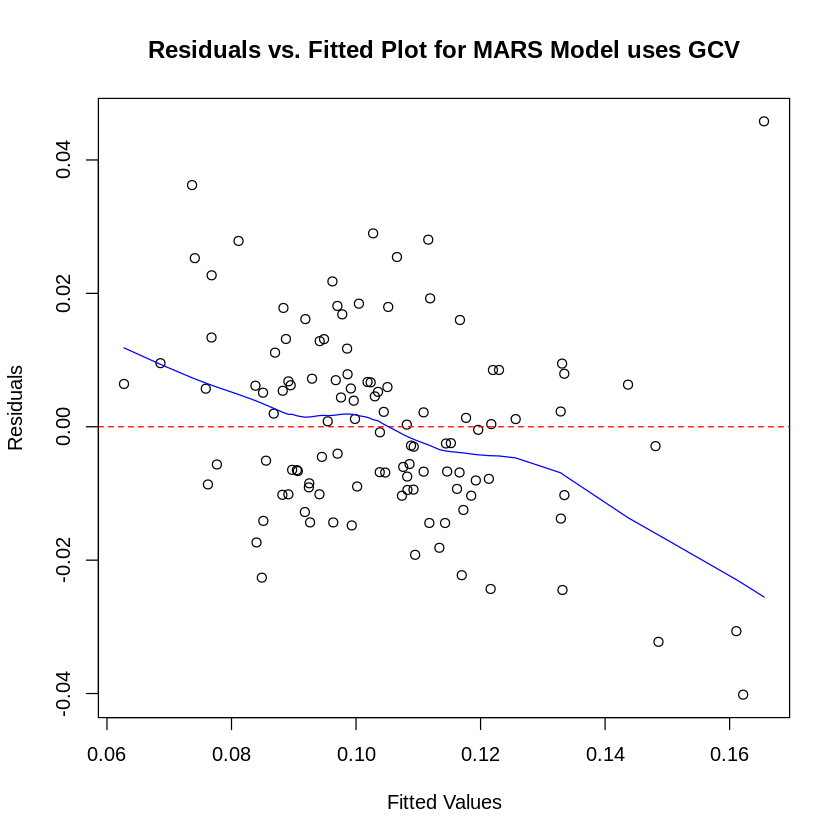

In [ ]:
#for GCV not replaced by CV (USED GCV)
#the prediction code line is
#pred_test <- predict(final_model, newdata = X_test)


fitted_values <- pred_test
residuals <- y_test[[1]] - pred_test

plot(fitted_values, residuals,
     main = "Residuals vs. Fitted Plot for MARS Model uses GCV", #GCV internal prunning
     xlab = "Fitted Values",
     ylab = "Residuals")

# Add a horizontal line at y=0 for reference
abline(h = 0, col = "red", lty = 2)

# Optional: Add a LOESS smooth line to see patterns
lines(lowess(fitted_values, residuals), col = "blue")

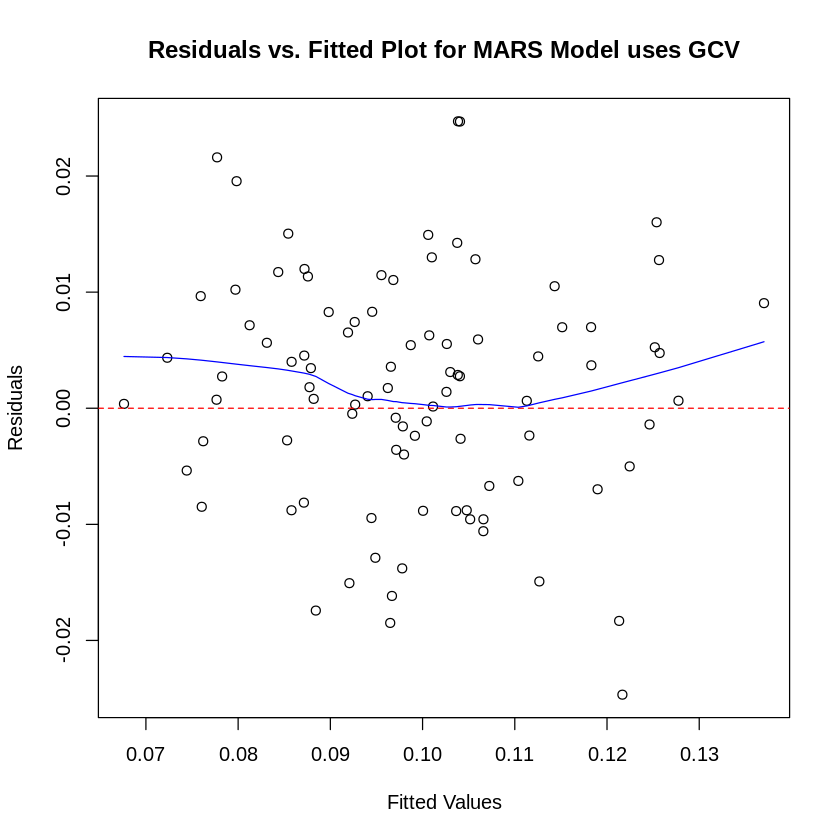

In [14]:
#for GCV not replaced by CV (USED GCV) OUTLIER REMOVED
#the prediction code line is
#pred_test <- predict(final_model, newdata = X_test)


fitted_values <- pred_test
residuals <- y_test[[1]] - pred_test

plot(fitted_values, residuals,
     main = "Residuals vs. Fitted Plot for MARS Model uses GCV", #GCV internal prunning
     xlab = "Fitted Values",
     ylab = "Residuals")

# Add a horizontal line at y=0 for reference
abline(h = 0, col = "red", lty = 2)

# Optional: Add a LOESS smooth line to see patterns
lines(lowess(fitted_values, residuals), col = "blue")

## **Log Transformation**

In [ ]:
train_df_copy <- train_df
y_test_copy <- y_test

In [ ]:
train_df_copy

PWP,sand,silt,clay,active_carbon,respiration,ag_stability,BNA,ph,p_index,c_nratio,per_carbon,per_nitrogen
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.10400000,59.0,31.7,9.3,343,0.85,49.1,36.1,5.1,9.04,9.53,1.62,0.17
0.10787000,60.7,26.1,13.2,301,0.37,24.1,22.8,5.5,14.62,11.58,1.39,0.12
0.11744700,49.6,39.9,10.5,422,0.71,31.2,48.7,5.7,17.43,13.13,1.97,0.15
0.08300000,62.3,26.4,11.3,340,0.46,38.5,25.8,5.2,9.72,13.08,1.57,0.10
0.08760100,66.0,26.4,7.5,361,0.62,23.2,24.4,5.6,25.51,12.64,1.39,0.11
0.09400000,60.2,27.0,12.8,306,0.71,26.4,32.5,6.4,14.16,8.29,1.16,0.26
0.11368278,64.1,28.7,7.3,446,0.81,54.2,30.7,6.0,10.59,15.62,2.03,0.13
0.11359026,51.5,31.9,16.7,208,0.73,18.1,39.9,5.4,8.09,9.90,0.99,0.10
0.08831522,66.1,28.0,5.9,507,0.71,64.6,42.7,6.0,18.78,14.07,1.97,0.14


In [ ]:
train_df_copy$PWP_log <- log(train_df_copy$PWP)
y_test_copy$PWP_log <- log(y_test_copy$PWP)

In [ ]:
train_df_copy <- train_df_copy[, -1]
y_test_copy <- y_test_copy[, -1]

In [ ]:
#sanity check
# sum(is.na(y_test))


In [ ]:
grid <- crossing(
  degree  = 1, nk = 50:70, nprune = 79:90, minspan = 1, endspan = 25:40
)

K_OUTER   <- 5        # 5 fold CV

In [ ]:
# Modify your grid search to use the transformed response
results <- pmap_dfr(grid, function(degree, nk, nprune, minspan, endspan) {
  folds <- make_folds(nrow(train_df_copy), k = K_OUTER)

  fold_stats <- lapply(folds, function(x) {
    tr_vec <- setdiff(seq_len(nrow(train_df_copy)), x)
    tr_subset <- train_df_copy[tr_vec, , drop = FALSE]
    te_subset <- train_df_copy[x, , drop = FALSE]

    # Model the transformed variable PWP_log
    fit <- earth(PWP_log ~ ., data = tr_subset, degree = degree, nk = nk, minspan = minspan, endspan = endspan, nprune = nprune)

    preds <- predict(fit, newdata = te_subset)

    # Evaluate using the transformed values
    c(RMSE = rmse(te_subset$PWP_log, preds),
      MAE = mae(te_subset$PWP_log, preds),
      R2 = cor(te_subset$PWP_log, preds)^2)
  })

  fold_mat <- do.call(rbind, fold_stats)
  tibble(
    degree = degree, nk = nk, nprune = nprune, minspan = minspan, endspan = endspan,
    RMSE = mean(fold_mat[, "RMSE"]),
    MAE = mean(fold_mat[, "MAE"]),
    R2 = mean(fold_mat[, "R2"])
  )
})

best_GCVs <- results %>% arrange(RMSE, MAE) %>% slice(3)
best_GCVs

degree,nk,nprune,minspan,endspan,RMSE,MAE,R2
<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,58,79,1,30,0.1222515,0.09435777,0.6488408


In [ ]:
# Fit the final model with the best hyperparameters
# Use the entire training dataset
final_mars_model_log <- earth(PWP_log ~ ., data = train_df_copy,
                              degree = 1,
                              nk = 58,
                              minspan = 1,
                              nprune = 79,
                              endspan = 30)

# Make predictions on the test set
preds_log <- predict(final_mars_model_log, newdata = X_test)

In [ ]:
# Back-transform the predictions
preds_original <- exp(preds_log)

# Now, you can evaluate performance using the original PWP values
rmse_original <- rmse(y_test[[1]], preds_original)
mae_original <- mae(y_test[[1]], preds_original)
r2_original <- cor(y_test[[1]], preds_original)^2

In [ ]:
metrics_log <- data.frame(
  Metric = c("MAE", "RMSE", "R-squared"),
  Value = c(mae_original, rmse_original, r2_original)
)

print(metrics_log)

     Metric      Value
1       MAE 0.01075130
2      RMSE 0.01367909
3 R-squared 0.57751863


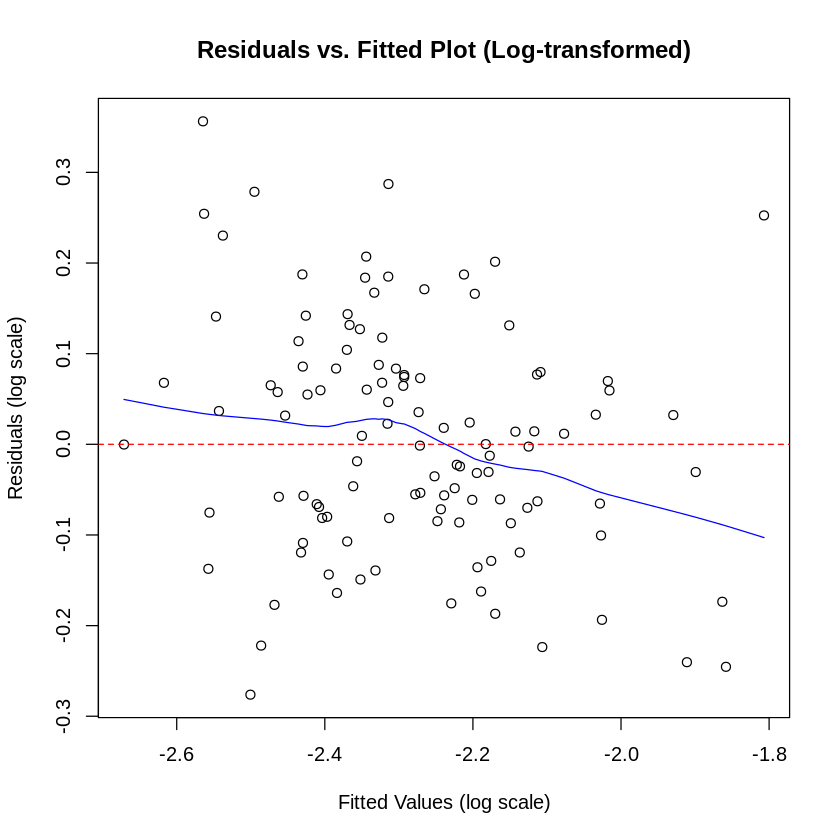

In [ ]:
# Use the log-transformed values for the residuals plot
fitted_values_log <- preds_log
residuals_log <- y_test_copy$PWP_log - fitted_values_log

plot(fitted_values_log, residuals_log,
     main = "Residuals vs. Fitted Plot (Log-transformed)",
     xlab = "Fitted Values (log scale)",
     ylab = "Residuals (log scale)")
abline(h = 0, col = "red", lty = 2)
lines(lowess(fitted_values_log, residuals_log), col = "blue")